# Image Classification with a fine-tuned CNN model using the Intel Image Classification Dataset 

## Problem Statement

The problem is to classify images of natural scenes around the world into six categories: buildings, forest, glacier, mountain, sea, and street. 
By Image classification we are aiming to categorize images into different classes. The dataset here contains images of natural scenes which can be used to train an image classification model. In this project, we build a CNN-based fine-tuning image classifier using the Intel Image Classification dataset and evaluate its performance on a validation set.


## Dataset

The dataset can be downloaded from the following link:
https://www.kaggle.com/puneet6060/intel-image-classification

It is available on Kaggle and consists of a total of 14,034 images divided into 6 categories.

## Steps

1. Data Preprocessing

2. CNN Model Creation

3. Fine-tuning the Model

4. Evaluation of Model

5. Prediction

## References
1. the idea of project and some slight parts of the model is deriven from the link below
https://www.kaggle.com/code/ahmadjaved097/multiclass-image-classification-using-cnn/notebook
 
2. some fundamental concepts and methods deriven from https://openai.com/blog/chatgpt

3. Course notebookes from https://github.com/RanFeldesh/deep-learning-tutorials

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.applications import VGG16
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split

In [2]:
#!unzip intel-image-classification.zip

In [3]:
# Setting the random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

### Data Preprocessing
In this section we Download the Intel Image Classification dataset from Kaggle and load it into a generator using the ImageDataGenerator class from TensorFlow. The generator should rescale the pixel values of the images to a range of 0 to 1.

Then we werform data augmentation techniques like rotation, flipping, and scaling to increase the dataset size.
Split the dataset into training and validation sets.

In [4]:
# Data Preprocessing
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
# Load the dataset into a generator
train_generator = train_datagen.flow_from_directory('intel-image-classification/seg_train/seg_train', target_size=(150, 150), batch_size=32, class_mode='categorical')
val_generator = val_datagen.flow_from_directory('intel-image-classification/seg_test/seg_test', target_size=(150, 150), batch_size=32, class_mode='categorical')


Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [6]:
# Label Mapping
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : buildings
1 : forest
2 : glacier
3 : mountain
4 : sea
5 : street


* this part is inspired by https://www.kaggle.com/code/ahmadjaved097/multiclass-image-classification-using-cnn/notebook 

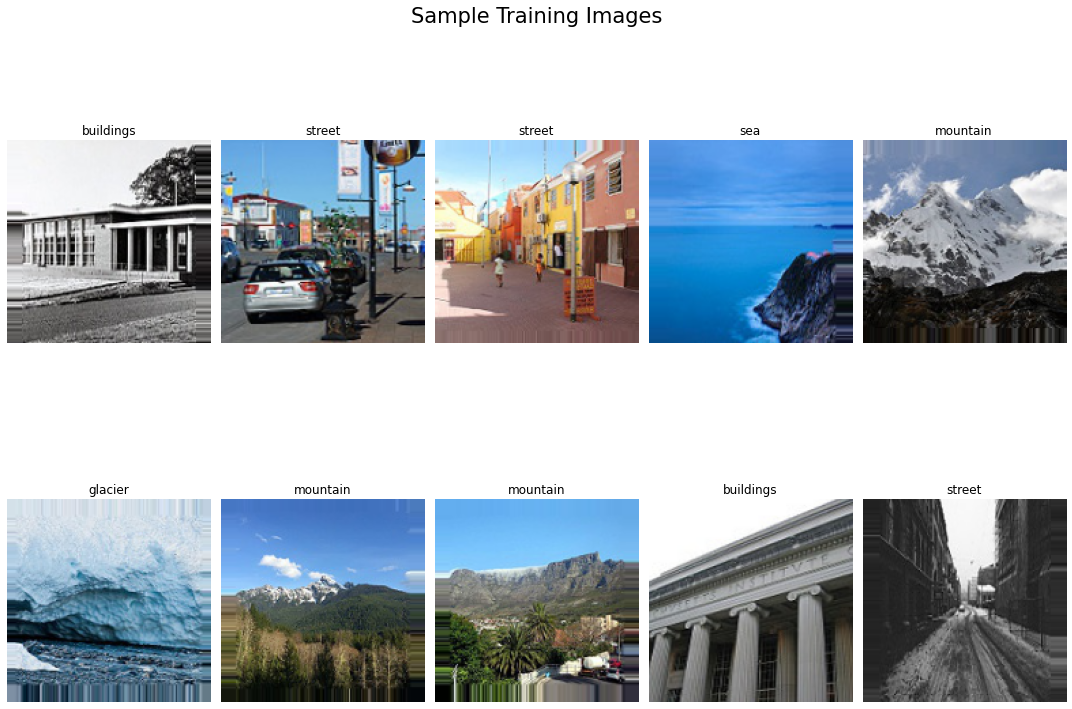

In [7]:
# Plot Samples of Training Dataset
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

## Define the CNN Model
To define a CNN architecture we use the Sequential class from TensorFlow. The architecture includes convolutional layers, pooling layers, and dense layers. 
We experimented with different numbers of layers and hyperparameters to improve the model's performance, then ended up with these numbers.

In [8]:
# CNN Model Creation
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

### Fine-tuning the Model
First we load the pre-trained VGG-16 model, which is trained on the ImageNet dataset.
then Freeze the weights of all the pre-trained layers and add a few new layers to the model.
We compile the model using the categorical_crossentropy loss function and the Adam optimizer.Then train the model on the training set using the fit method from Keras.
Finally, we Fine-tune the model by unfreezing the last 4 layers and re-training the model on the training set.
This section is created with the help of https://openai.com/blog/chatgpt

In [29]:
# Fine-tuning the Model using a pre-trained model
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freezing all layers
for layer in vgg_model.layers:
    layer.trainable = False


In [30]:
#Adding new layers
model = Sequential()
model.add(vgg_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [10]:
history = model.fit(train_generator, steps_per_epoch=len(train_generator), epochs=10, validation_data=val_generator, validation_steps=len(val_generator))


Epoch 1/10
439/439 [==============================] - 107s 230ms/step - loss: 1.0657 - accuracy: 0.5695 - val_loss: 0.8133 - val_accuracy: 0.6890
Epoch 2/10
439/439 [==============================] - 101s 230ms/step - loss: 0.8061 - accuracy: 0.6933 - val_loss: 0.7150 - val_accuracy: 0.7333
Epoch 3/10
439/439 [==============================] - 96s 218ms/step - loss: 0.6815 - accuracy: 0.7509 - val_loss: 0.6698 - val_accuracy: 0.7533
Epoch 4/10
439/439 [==============================] - 96s 218ms/step - loss: 0.5950 - accuracy: 0.7862 - val_loss: 0.5479 - val_accuracy: 0.8067
Epoch 5/10
439/439 [==============================] - 93s 212ms/step - loss: 0.5363 - accuracy: 0.8065 - val_loss: 0.5007 - val_accuracy: 0.8280
Epoch 6/10
439/439 [==============================] - 98s 224ms/step - loss: 0.4780 - accuracy: 0.8281 - val_loss: 0.5291 - val_accuracy: 0.8040
Epoch 7/10
439/439 [==============================] - 96s 218ms/step - loss: 0.4409 - accuracy: 0.8437 - val_loss: 0.4598 - val_

In [31]:
# Unfreezing last 4 layers of the model 
for layer in model.layers[:-4]:
    layer.trainable = False

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [33]:
history = model.fit(train_generator, steps_per_epoch=len(train_generator), epochs=10, validation_data=val_generator, validation_steps=len(val_generator))


Epoch 1/10
439/439 [==============================] - 120s 266ms/step - loss: 0.5879 - accuracy: 0.7850 - val_loss: 0.3593 - val_accuracy: 0.8687
Epoch 2/10
439/439 [==============================] - 115s 262ms/step - loss: 0.4396 - accuracy: 0.8366 - val_loss: 0.3544 - val_accuracy: 0.8680
Epoch 3/10
439/439 [==============================] - 114s 260ms/step - loss: 0.4081 - accuracy: 0.8501 - val_loss: 0.3314 - val_accuracy: 0.8723
Epoch 4/10
439/439 [==============================] - 116s 264ms/step - loss: 0.3999 - accuracy: 0.8506 - val_loss: 0.3211 - val_accuracy: 0.8757
Epoch 5/10
439/439 [==============================] - 113s 256ms/step - loss: 0.3832 - accuracy: 0.8545 - val_loss: 0.3229 - val_accuracy: 0.8783
Epoch 6/10
439/439 [==============================] - 107s 243ms/step - loss: 0.3647 - accuracy: 0.8670 - val_loss: 0.3346 - val_accuracy: 0.8753
Epoch 7/10
439/439 [==============================] - 111s 254ms/step - loss: 0.3579 - accuracy: 0.8710 - val_loss: 0.3453 -

### Evaluating the Model
To evaluate the performance of the model on the validation set, we recall the Validation Accuracy. 

The Validation accuracy is 0.83


In [11]:
# Evaluate the model
val_loss, val_acc = model.evaluate(val_generator)
print('Validation accuracy:', val_acc)

94/94 [==============================] - 4s 43ms/step - loss: 0.4706 - accuracy: 0.8343
Validation accuracy: 0.8343333601951599


### Prediction
We test the model using the test set from the dataset to check its performance.
We load random images and pass them to the model's predict method to obtain a probability distribution over the different classes.

Found 3000 images belonging to 6 classes.
94/94 [==============================] - 6s 63ms/step


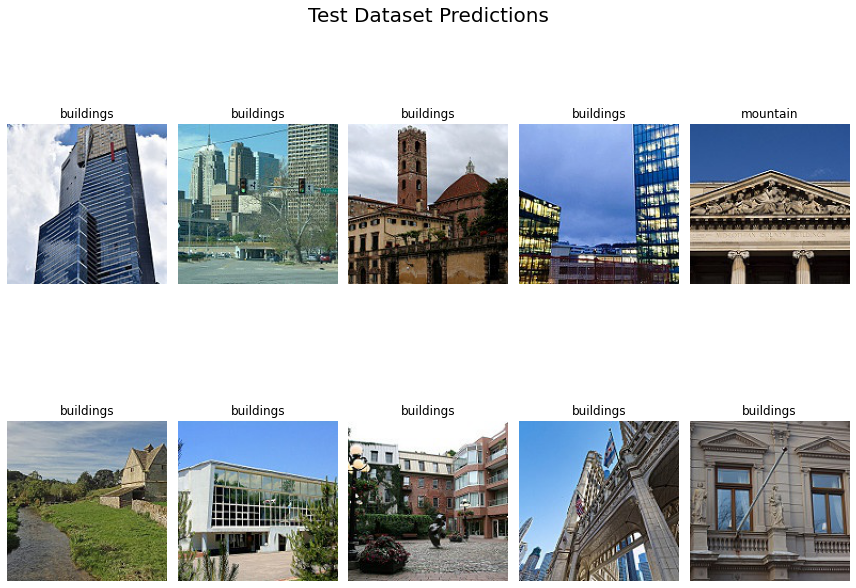

In [28]:
# Prediction
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory('intel-image-classification/seg_test/seg_test', target_size=(150, 150), batch_size=32, shuffle=False, class_mode='categorical')

pred = model.predict(test_generator)
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(pred[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

## Plotting the Model Metrics
Plotting training and validation accuracy and loss rate, as we see the validation accuracy first is above the train accuracy , but after running half of the epochs, it is progressing along with the train accuracy.
Similarly, we see the training and validation loss decrease over time. This indicates that the model is getting better at minimizing the difference between the predicted and actual labels.


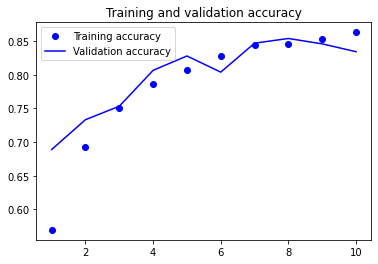

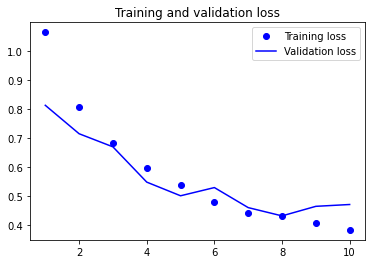

In [12]:
# Plot Accuracy and Loss curves
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()